In [1]:
# !pip install wordcloud nltk matplotlib pandas numpy seaborn xgboost scikit-learn

### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
STOPWORDS = set(stopwords.words('english'))


from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

import warnings
warnings.filterwarnings('ignore')

### Load Dataset

In [3]:
data = pd.read_csv(r'output.csv')
#if tsv then below code
#data = pd.read_csv(r'output.tsv',delimiter = '\t',quoting=3)

### Data Analysis (EDA)

In [4]:
data.shape #shape of the data rows,column

(3150, 5)

In [5]:
data.head() #feedback 0 means not given feedback and 1 means given feedback

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [6]:
data.columns### Column names or features

Index([' rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [7]:
data.rename(columns={' rating' : 'rating'},inplace=True)

In [8]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

There is one record with no 'verified_reviews' is null

In [9]:
### Getting the record where 'verified_reviews' is null

data[data['verified_reviews'].isnull() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [10]:
### We can replace Nan by empty string or we can also drop it

In [11]:
data['verified_reviews'].fillna('',inplace=True) #filling na with blank ''

In [12]:
data[data['verified_reviews'].isnull() == True] #checking null value is there or not

,rating,date,variation,verified_reviews,feedback


In [13]:
#creating a new column 'Length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [14]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [15]:
# The length column is new generated column which have length of verified reviews text in that column rowwise.

In [16]:
# Randomly checking for 10th record

In [17]:
print(data.iloc[5]['verified_reviews'],'\n')
print(len(data.iloc[5]['verified_reviews']),'\n')
print(data.iloc[5]['length'])

I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do. 

172 

172


In [18]:
# Datatypes of the features

In [19]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [20]:
# Here as we show above columns named date,variation,verified_reviews are object dtype and rating,feedback and length column are integer dtype

### Analyzing 'rating' column

In [21]:
### This column refers to the rating of the variation given by the user.

In [22]:
print(data['rating'].value_counts())

rating
5    2286
4     455
1     161
3     152
2      96
Name: count, dtype: int64


Let's plot the above values in a bar graph

<Axes: xlabel='rating'>

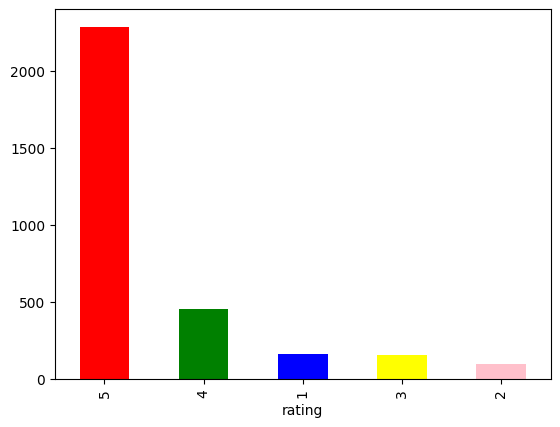

In [23]:
data['rating'].value_counts().plot.bar(color=['red','green','blue','yellow','pink'])

In [24]:
### Percentage distribution of rach rating

In [25]:
print('\033[1mIn Percentage\n\n\033[0m',round(data['rating'].value_counts()/data.shape[0]*100,2))

In Percentage

 rating
5    72.57
4    14.44
1     5.11
3     4.83
2     3.05
Name: count, dtype: float64


In [26]:
### Let's plot the above values in a pie chart

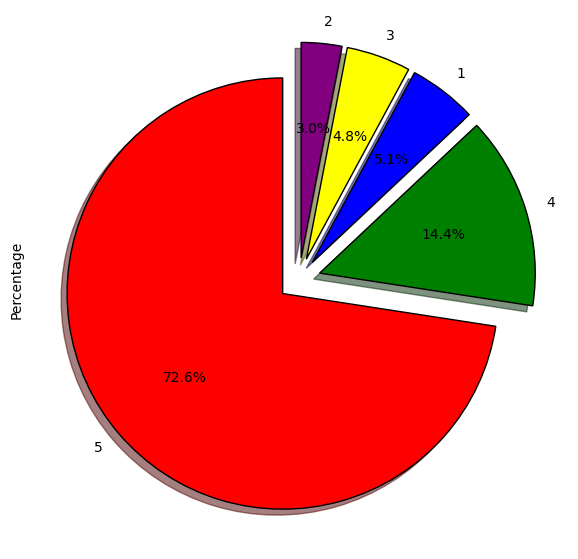

In [27]:
fig = plt.figure(figsize=(7,7))

colors = ('red','green','blue','yellow','purple')

wp = {'linewidth' : 1, 'edgecolor':'black'} #used to customize the appearance of the wedges, such as their color, width, and edge color.

tags = data['rating'].value_counts()/data.shape[0]

explode = (0.1,0.1,0.1,0.1,0.1)

tags.plot.pie(autopct = '%1.1f%%',shadow=True,colors = colors,startangle = 90,
             wedgeprops = wp,explode=explode,label = 'Percentage')

from io import BytesIO
graph = BytesIO()
fig.savefig(graph,format='png')

In [28]:
with open('figure.png', 'wb') as f:
    f.write(graph.getvalue()) #save the image

### Analyzing 'feedback' column

The column refers to the feedback of the verified review

In [29]:
# Distinct values of 'feedback' and its count

print(data['feedback'].value_counts())

feedback
1    2893
0     257
Name: count, dtype: int64


In [30]:
# for feedback value 0

In [31]:
# Extracting the 'verified_reviews' value for one record with feedback = 0

In [32]:
review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']

In [33]:
review_0

'Sound is terrible if u want good music too get a bose'

In [34]:
review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']

In [35]:
review_1 # Extracting the 'verified_reviews' value for one record with feedback = 1

'Loved it!'

In [36]:
### Frome above we can see that feeback 0 is for negative review and feeback 1 is positive review

In [37]:
### Let's plot the feedback value count in bar graph

# bar graph for  visualize the total counts of each feedback

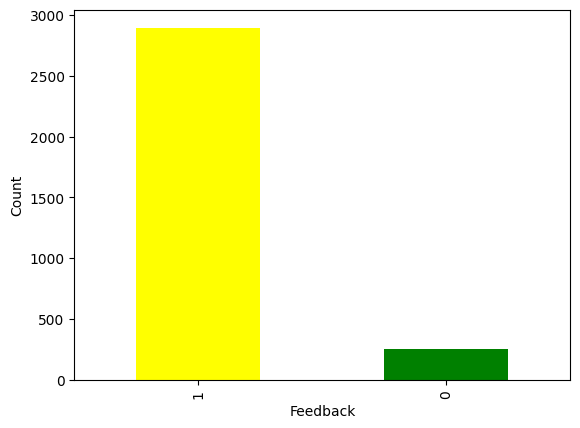

In [38]:
data['feedback'].value_counts().plot.bar(color = ['yellow','green'])
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [39]:
# Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of feeback 

In [40]:
print('\033[1mIn Percentage\n\n\033[0m',round(data['feedback'].value_counts()/data.shape[0]*100,2))

In Percentage

 feedback
1    91.84
0     8.16
Name: count, dtype: float64


In [41]:
### 91.84 % are positive reviews and 8.13 % are negative reviews

<Axes: ylabel='Percentage'>

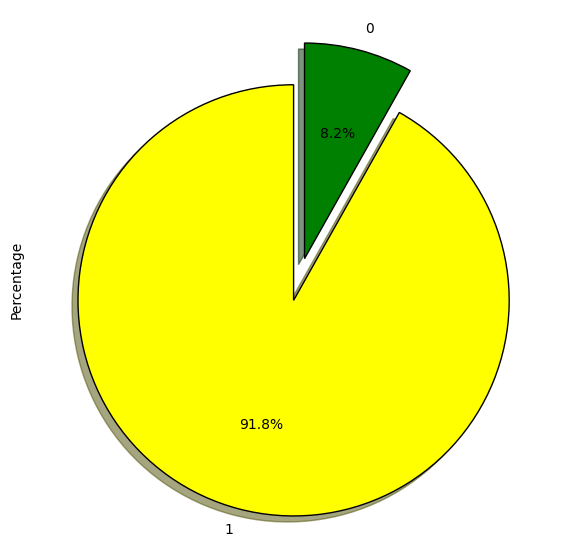

In [42]:
fig = plt.figure(figsize=(7,7))

colors = ('yellow','green')

wp = {'linewidth' : 1, 'edgecolor':'black'} #used to customize the appearance of the wedges, such as their color, width, and edge color.

tags = data['feedback'].value_counts()/data.shape[0]

explode = (0.1,0.1)

tags.plot.pie(autopct = '%1.1f%%',shadow=True,colors = colors,startangle = 90,
             wedgeprops = wp,explode=explode,label = 'Percentage')


In [43]:
### Let's see the rating values for different values of 'feedback'

In [44]:
#feeback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     96
Name: count, dtype: int64

In [45]:
#feeback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

In [46]:
### for review 1,2 rating is 0 negative and for review 3,4,5 rating is 1  positive 

### Analyzing 'variation' column

In [47]:
### refers to the variation or type of amazon alexa products

In [48]:
print(data['variation'].value_counts())

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


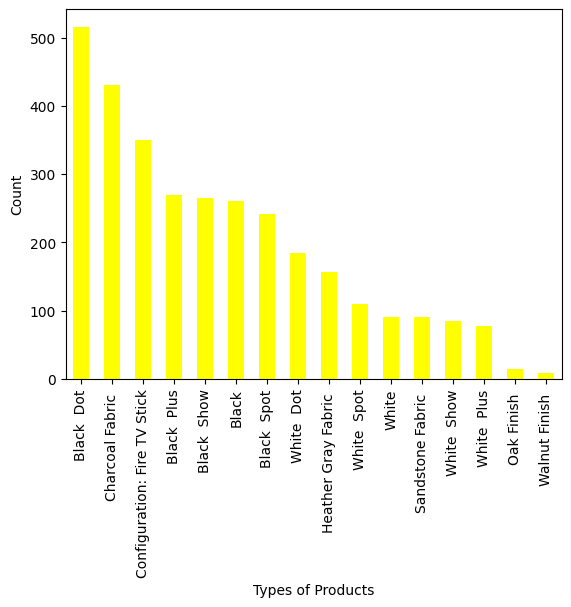

In [49]:
data['variation'].value_counts().plot.bar(color = ['yellow'])
plt.xlabel('Types of Products')
plt.ylabel('Count')
plt.show()

In [50]:
print('\033[1mIn Percentage\n\n\033[0m',round(data['variation'].value_counts()/data.shape[0]*100,2))

In Percentage

 variation
Black  Dot                      16.38
Charcoal Fabric                 13.65
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.41
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.98
White  Spot                      3.46
White                            2.89
Sandstone Fabric                 2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


<Axes: ylabel='Percentage'>

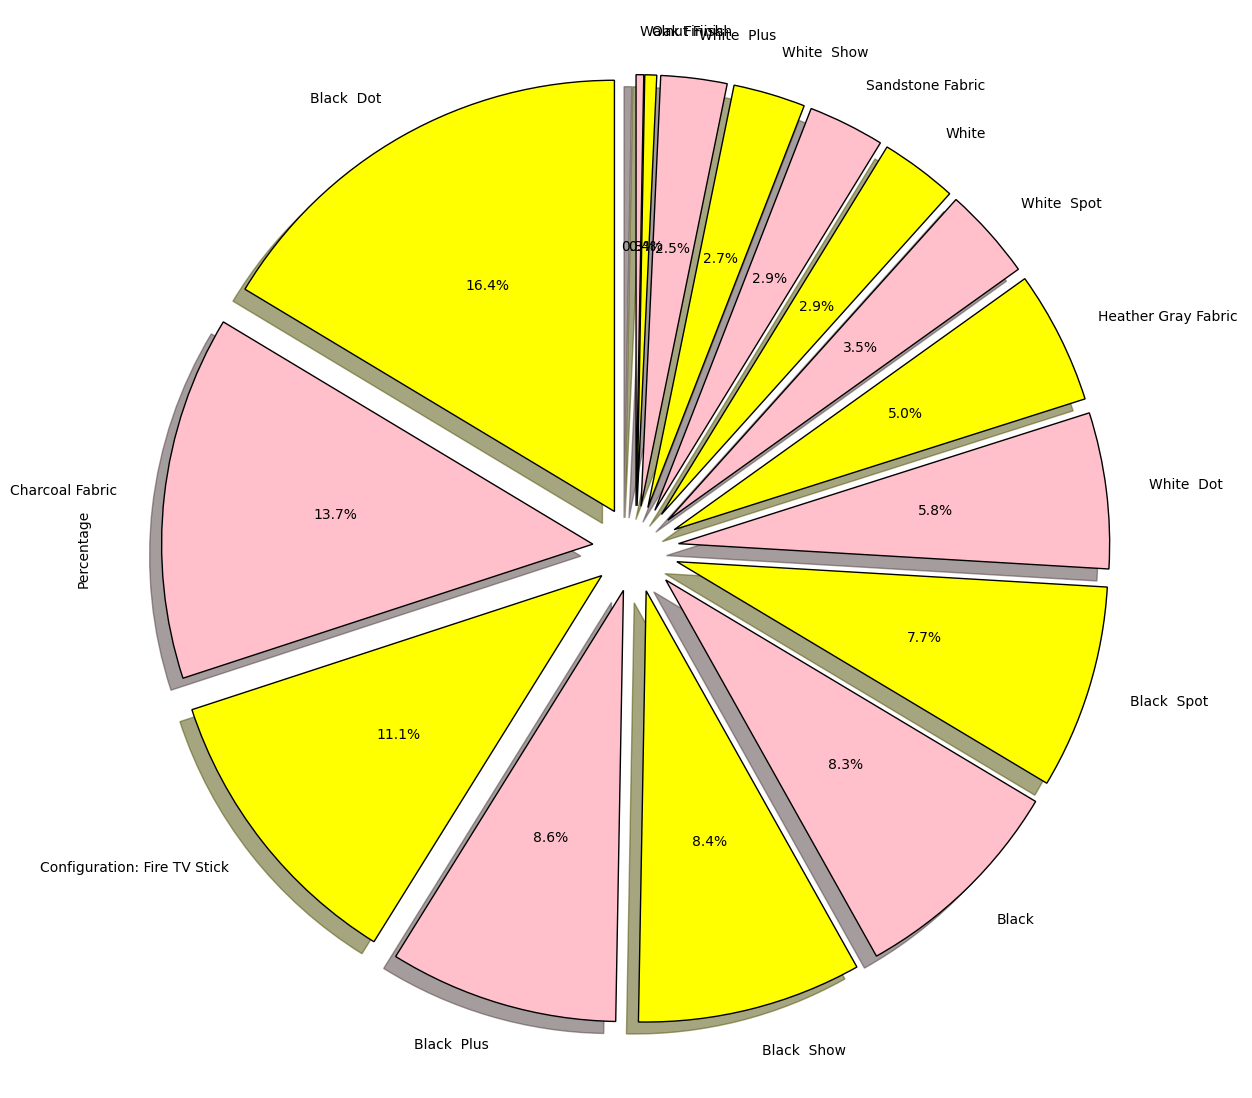

In [51]:
fig = plt.figure(figsize=(14,14))

colors = ('yellow','pink')

wp = {'linewidth' : 1, 'edgecolor':'black'} #used to customize the appearance of the wedges, such as their color, width, and edge color.

tags = data['variation'].value_counts()/data.shape[0]

explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1)

tags.plot.pie(autopct = '%1.1f%%',shadow=True,colors = colors,startangle = 90,
             wedgeprops = wp,explode=explode,label = 'Percentage')


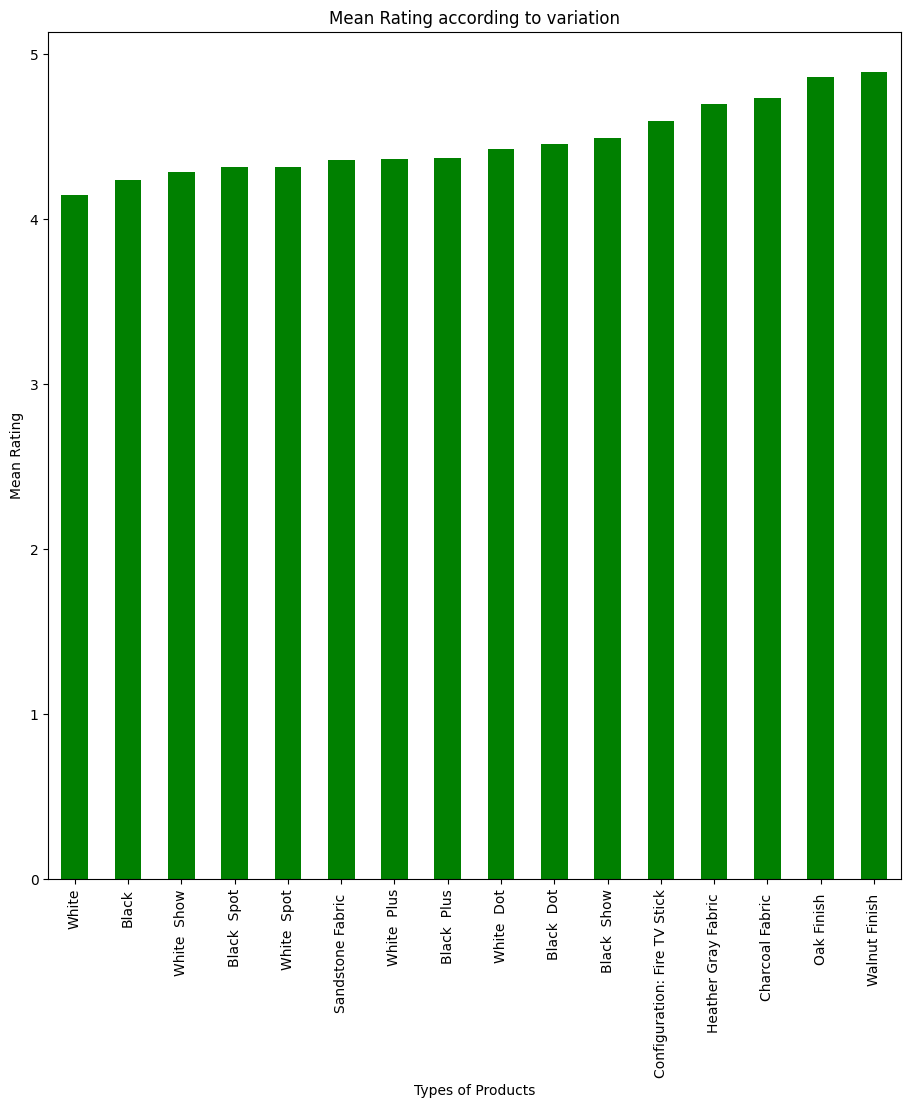

In [52]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = ['green'],figsize = (11,11))
plt.title('Mean Rating according to variation')
plt.xlabel('Types of Products')
plt.ylabel('Mean Rating')
plt.show()

In [53]:
### Analyzing 'verified_reviews' column

#this column contains the textual review given by the user for a variation for the product

In [54]:
data['length'].describe()

count    3150.000000
mean      132.048254
std       182.100859
min         0.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

In [55]:
### Length analysis for full dataset

[Text(0.5, 1.0, 'Distribution of length of review')]

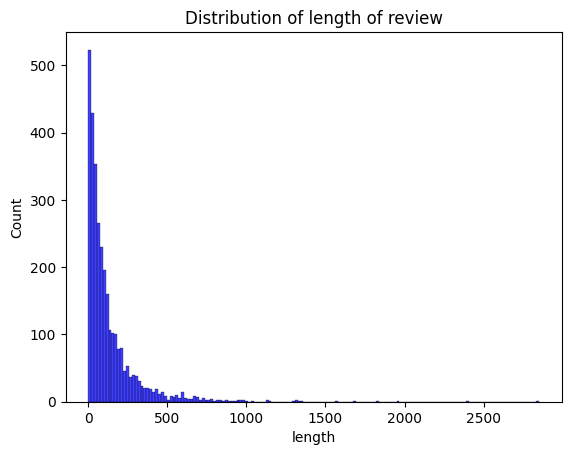

In [56]:
sns.histplot(data['length'],color = 'blue').set(title = "Distribution of length of review")

Length analysis when feedback is 0 (negative)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

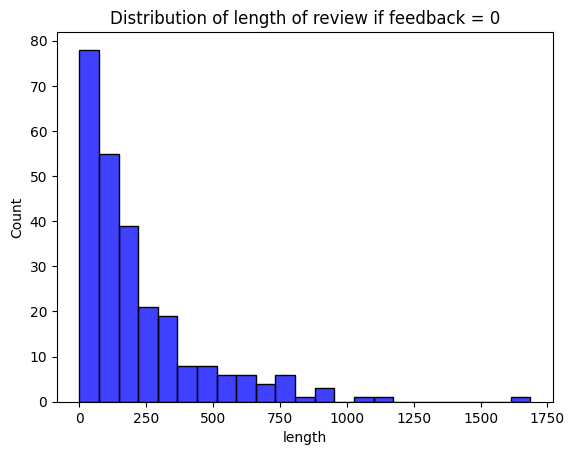

In [57]:
sns.histplot(data[data['feedback'] == 0]['length'],color = 'blue').set(title = "Distribution of length of review if feedback = 0")

length analysis when feedback is 1(positive)

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

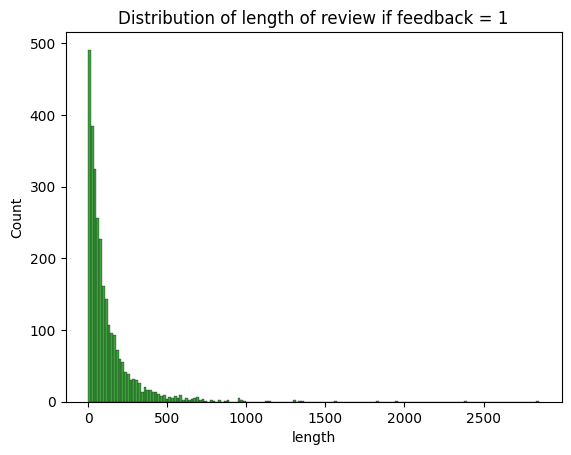

In [58]:
sns.histplot(data[data['feedback'] == 1]['length'],color = 'green').set(title = "Distribution of length of review if feedback = 1")

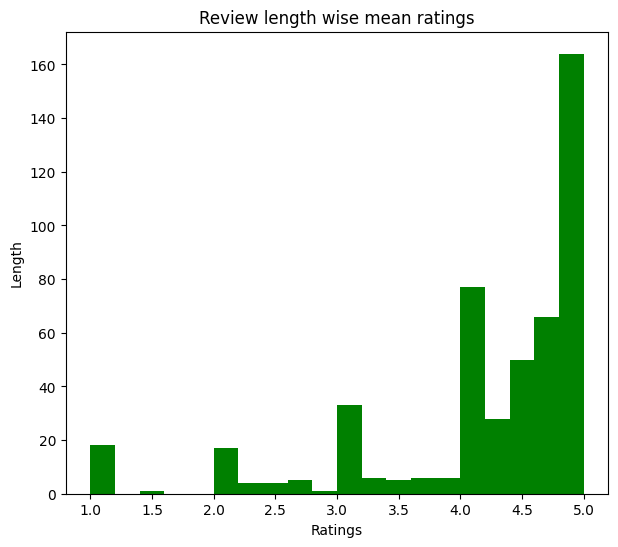

In [59]:
data.groupby('length')['rating'].mean().plot.hist(color = ['green'],figsize = (7,6),bins = 20)
plt.title('Review length wise mean ratings')
plt.xlabel('Ratings')
plt.ylabel('Length')
plt.show()

In [60]:
# CountVectorizer is a text preprocessing technique commonly used in natural language processing (NLP) tasks for converting a collection of text documents into a numerical representation.

In [61]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

In [62]:
words

<3150x3784 sparse matrix of type '<class 'numpy.int64'>'
	with 33005 stored elements in Compressed Sparse Row format>

In [63]:
# Combine all reviews

In [64]:
reviews = "".join(review for review in data['verified_reviews'])

In [65]:
reviews

'Love my Echo!Loved it!Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home.I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.MusicI received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can’t wait to see what else it can do.Without having a cellphone, I cannot use many of her features. I have an iPad but do not see that of any use.  It IS a great alarm.  If u r almost deaf, you can hear her alarm in the bedroom from out in the living room, so that is reason enough to keep her.It is fun to ask random questions to hear her response.  She does not seem to be very smartbon politics yet.I think this is the 5th one I\'ve purchased. I\'m working on getting

In [66]:
wc = WordCloud(background_color='white',max_words=100)

In [67]:
#Generate and plot wordcloud

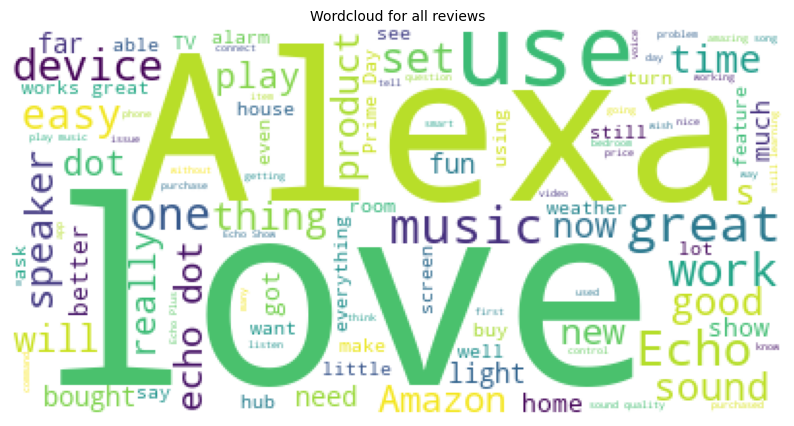

In [68]:
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews',fontsize = 10)
plt.axis("off")
plt.show()

Lets find the unique words in each feedback category

In [69]:
neg_reviews = "".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

In [70]:
pos_reviews = "".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

In [71]:
#Findings words from reviews which present in that feedback category only

In [72]:
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = "".join(unique_negative)

In [73]:
print(unique_negative)

siri,accuratelydeals.soundbosenotfeatures.stopped,didn'tcommands!?working?sadworthless.reallyplug-inassumptionsellrechargeablebattery.boomflexibilityalexa.it'sthingsilapsed,differentiateamongspeaksnobodyher...notagain.tooenterpasswordalexaon..itemunresponsiverequests.thisselectsendingasap.money.irefund1.package.refundspackage.both???!!!notworkingi'mspokenprompthat.itstopped.refundpooraway.nevertechiedollarstore.then.initially,'alexa'footyelling.echos/echorefurbished.iperformingoften,nothing.dot.dontthis....fmreceptionlive.horrible.nativeamericanswhosetexasaccentbirthadditionallyreceptionpoormarginal.extendertendifference.disconnecteddustcollectors.itemworked.broken.&#34;fixes&#34;accomplishedconnection.&#34;never&#34;&#34;certified&#34;pooracknowledgeindicated.perfectly.very!!!!thiscrashedcrashed,over.orangefreezerebootfreezesentence.holdingactionbuyerit.doestimei'veit.nowwearyactively3-4,concerning.releasewidespreadfirmwarepreventhave,yet.therefix.registered$39.99(sameones),brand,span

In [74]:
unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = "".join(unique_positive)

In [75]:
print(unique_positive)

echo!lovedit!sometimesgame,home.iyrlearnsdinosaurs,gamescategories.well.musicigift.accessible,do.withoutcellphone,ipadalarm.rdeaf,bedroomher.itrandomresponse.smartbonpoliticsyet.i5thpurchased.roomhouse.specifilycontrollinghouse.looksgreatlovelistenedsongschildhood!news,weather,information!great!i85dad,talksconstantly.ilearningeveyday!figuringunderstand.laughtimesimotherkneefastdid.sheenjoysdo...alexasong,where,cookthat!love,love,love!!justexpected....ihatesit.reallypurchase.up.wetoy.householdmember!learnfeatuesbenefitsit.we2ndimprovementsoundishortergreaterfabric/colorchoices.ringtop,plus/minusbuttons.ringwcomforting.:)standardusbcharger/portroundpin.alexa/echo/computer.like?:)loveunderstandscommandsspecificplaylistssongsspotify.lackingmajorprograms.wealexa!itunes,podcastsanypod,flashbriefingmorning.relycustomlists.volume.we'rewe'lluses.sometimeswe'resaying.havedays.size,stationedcounterintrusiveat.iplaysaskibedroom,improveddidntimprovementgeneration.amazingproductioperate,loadsfun.itm

In [76]:
wc = WordCloud(background_color='white',max_words=100)

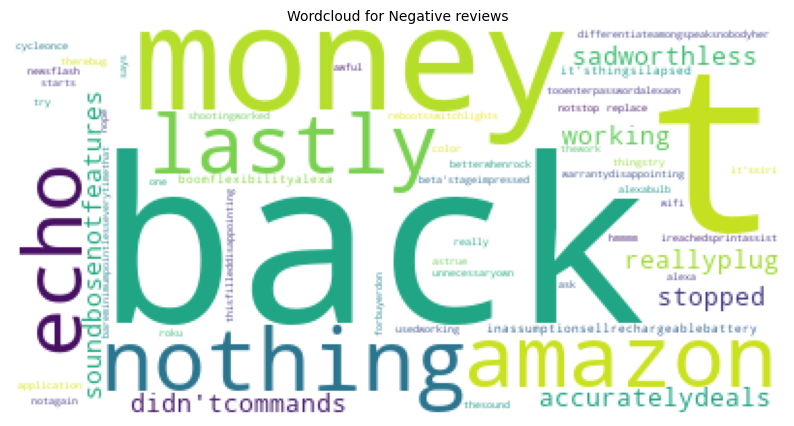

In [77]:
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for Negative reviews',fontsize = 10)
plt.axis("off")
plt.show()

In [78]:
### we can see the negative words in the wordcloud like stopped,nothing,didn't commands

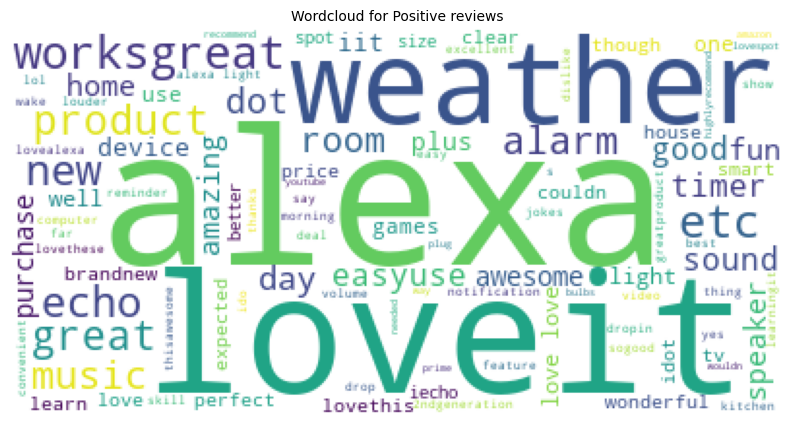

In [79]:
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for Positive reviews',fontsize = 10)
plt.axis("off")
plt.show()

In [80]:
### we can see the positive words in the wordcloud like love it,great,good,well,worksgreat

In [81]:
### Preprocessing and Modeling 

In [82]:
# To build the corpus from the 'verified_reviews' we perform the following - 

#1. replace any non alphabet characters with space
#2. covert to lower case split into words
#3. iterate over the individual words and if not in stopwords then add them into the stemmed form of word to the corpus

In [83]:
corpus = []
lemmantizer = WordNetLemmatizer()
for i in range(0,data.shape[0]):
    review = re.sub('[^a-z]', ' ',data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [lemmantizer.lemmatize(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [84]:
corpus

['ove cho',
 'oved',
 'ometimes playing game answer question correctly lexa say got wrong answer like able turn light away home',
 'lot fun thing yr old learns dinosaur control light play game like category nice sound playing music well',
 'usic',
 'received echo gift needed another luetooth something play music easily accessible found smart speaker wait see else',
 'ithout cellphone cannot use many feature ad see use great alarm f u r almost deaf hear alarm bedroom living room reason enough keep fun ask random question hear response seem smartbon politics yet',
 'think th one purchased working getting one every room house really like feature offer specifily playing music chos controlling light throughout house',
 'look great',
 'ove listened song heard since childhood get news weather information great',
 'sent year old ad talk constantly',
 'love earning knew thing eveyday till figuring everything work far easy use understand make laugh time',
 'purchased mother knee problem give som

In [85]:
# Using Count Vectorizer to create Bag of Words

In [86]:
cv = CountVectorizer(max_features=10000)

In [87]:
# Storing independant and dependant variables in x and y

In [88]:
x = cv.fit_transform(corpus).toarray()

In [89]:
y = data['feedback'].values

In [90]:
#Saving the Count Vectorizer

In [91]:
pickle.dump(cv,open('Models/countVectorizer.pkl','wb'))

In [92]:
# Checking shape of x and y

In [93]:
x.shape

(3150, 3911)

In [94]:
y.shape

(3150,)

In [95]:
### Split data into training and testing

In [96]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=15)

In [97]:
print("X Train Shape:- ",X_train.shape)
print("X Test Shape:- ",X_test.shape)
print("Y Train Shape:- ",y_train.shape)
print("Y Test Shape:- ",y_test.shape)

X Train Shape:-  (2520, 3911)
X Test Shape:-  (630, 3911)
Y Train Shape:-  (2520,)
Y Test Shape:-  (630,)


In [98]:
print("X Train Max Value:- ",X_train.max())
print("X Test Max Value:- ",X_test.max())

X Train Max Value:-  12
X Test Max Value:-  7


In [99]:
# Scalling data between o to 1

In [100]:
scaler = MinMaxScaler() #default range 0 to 1

In [101]:
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.fit_transform(X_test)

In [102]:
#Saving the scaler model

In [131]:
pickle.dump(scaler,open('Models/Scaler.pkl','wb'))

# Random Forest

In [104]:
#fitting scaled X_train and y_train on Random Forest Classifier

In [105]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl,y_train)

RandomForestClassifier()

In [106]:
#Accuracy of the model on training and testing data

In [107]:
print("Training Accuracy: ",model_rf.score(X_train_scl,y_train))
print("Testing Accuracy: ",model_rf.score(X_test_scl,y_test))

Training Accuracy:  0.9940476190476191
Testing Accuracy:  0.9365079365079365


In [108]:
y_pred = model_rf.predict(X_test_scl)

In [109]:
# Confusion matrix

In [110]:
cm = confusion_matrix(y_test,y_pred)

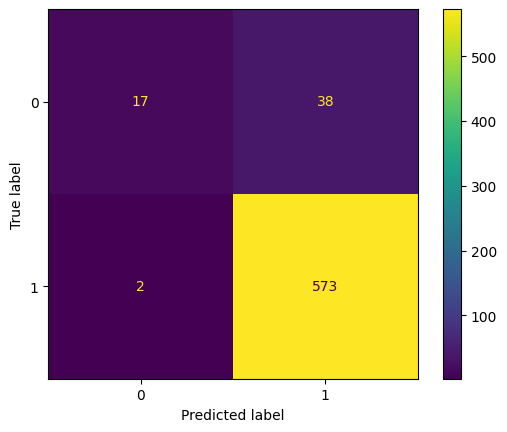

In [111]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

### K-Fold Cross-Validation

K-fold cross-validation is a technique used in machine learning and statistical modeling to evaluate the performance of a predictive model. It involves dividing the dataset into k subsets or folds of approximately equal size.

In [112]:
accuracies = cross_val_score(estimator=model_rf,X = X_train_scl,y = y_train,cv = 10)
print('Accuracy:- ',accuracies.mean())
print('Standard Deviation:- ',accuracies.std())

Accuracy:-  0.9341269841269841
Standard Deviation:-  0.008361629962581527


In [113]:
# Applying grid search to get the optimal parameters on random forest

In [114]:
params = {
    'bootstrap' : [True],
    'max_depth' : [80,100],
    'min_samples_split': [8,12],
    'n_estimators' : [100,300]
}

In [115]:
cv_object = StratifiedKFold(n_splits=2)

grid_Search = GridSearchCV(estimator=model_rf,param_grid = params,cv = cv_object,verbose = 0, return_train_score=True)
grid_Search.fit(X_train_scl,y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [116]:
print('Best Parameter Combination ',grid_Search.best_params_)

Best Parameter Combination  {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 300}


In [117]:
print('Cross validation mean accuracy on training dataset',grid_Search.cv_results_['mean_train_score'].mean()*100)
print('Cross validation mean accuracy on test dataset',grid_Search.cv_results_['mean_test_score'].mean()*100)
print('Accuracy score for test set :',accuracy_score(y_test,y_pred))

Cross validation mean accuracy on training dataset 96.83035714285715
Cross validation mean accuracy on test dataset 92.23710317460319
Accuracy score for test set : 0.9365079365079365


### XgBoost

In [118]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [119]:
print('Training Accuracy',model_xgb.score(X_train_scl,y_train))
print('Testing Accuracy',model_xgb.score(X_test_scl,y_test))

Training Accuracy 0.9686507936507937
Testing Accuracy 0.9301587301587302


In [120]:
y_preds = model_xgb.predict(X_test)

In [121]:
#Confusion Matrix
cm = confusion_matrix(y_test,y_preds)

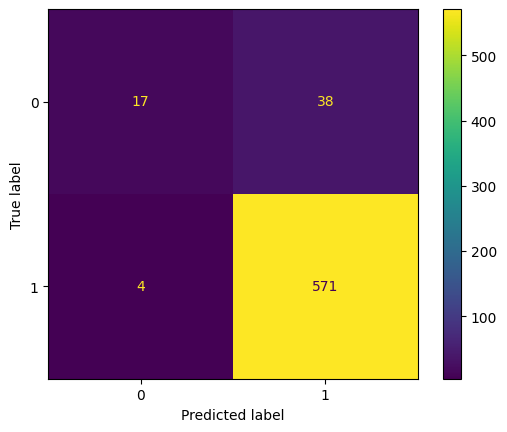

In [122]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

### Decision Tree Classifier

In [123]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl,y_train)

DecisionTreeClassifier()

In [124]:
#Accuracy of the model on training and testing data

In [125]:
print("Training Accuracy: ",model_dt.score(X_train_scl,y_train))
print("Testing Accuracy: ",model_dt.score(X_test_scl,y_test))

Training Accuracy:  0.9940476190476191
Testing Accuracy:  0.9174603174603174


In [126]:
y_pred = model_dt.predict(X_test_scl)

In [127]:
# Confusion matrix

In [128]:
cm = confusion_matrix(y_test,y_pred)

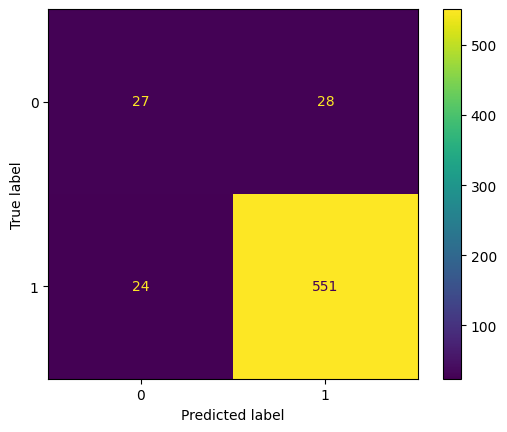

In [129]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [130]:
pickle.dump(model_rf,open('Models/RANDOMFORESTCLASSIFIER.pkl','wb'))
pickle.dump(model_dt,open('Models/DECISIONTREECLASSIFIER.pkl','wb'))
pickle.dump(model_xgb,open('Models/XGBOOSTCLASSIFIER.pkl','wb'))